In [1]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### FitzHugh-Nagumo

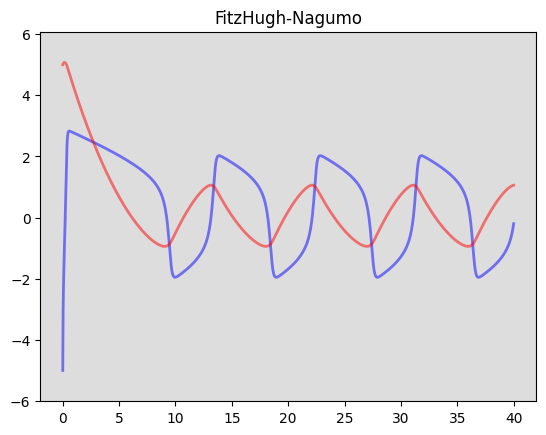

In [2]:
# define FitzHugh-Nagumo model dynamic
def FN(y, t, a, b, c):
	V, R = y
	dVdt = c * (V - np.power(V,3)/3.0 + R)
	dRdt = -1./c * (V - a + b*R)
	return (dVdt,dRdt)

# model parameters 
a, b, c = 0.2, 0.2, 3
# initial condition
V0 = -5
R0 = 5
y0 = V0, R0
# time point for evaluation
tdata = np.linspace(0, 40, 1281)
# integration
xdata = odeint(FN, y0, tdata, args = (a,b,c))
# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('FitzHugh-Nagumo')
plt.show()

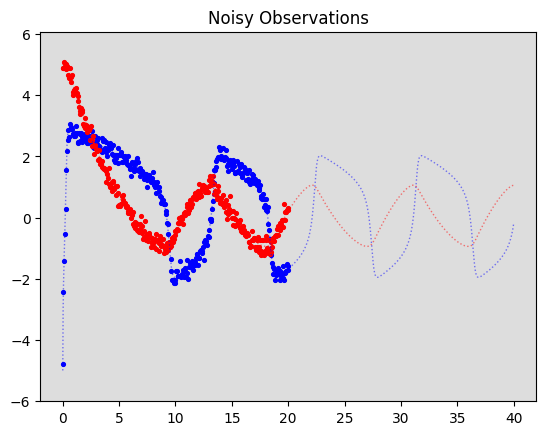

In [3]:
# setting
seed = 188714368 # random seed
noise = [0.15,0.15] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [4]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

/home/chuang397/.venv/lib64/python3.8/site-packages/linear_operator/utils/sparse.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


1/1000 iteration: 54.422108
200/1000 iteration: 12.259363
400/1000 iteration: 7.349340
600/1000 iteration: 5.520794
800/1000 iteration: 4.613196
1000/1000 iteration: 4.087358
run time: 38.38 seconds


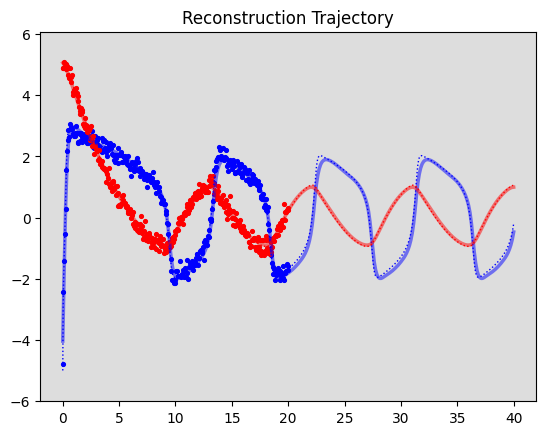

In [5]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

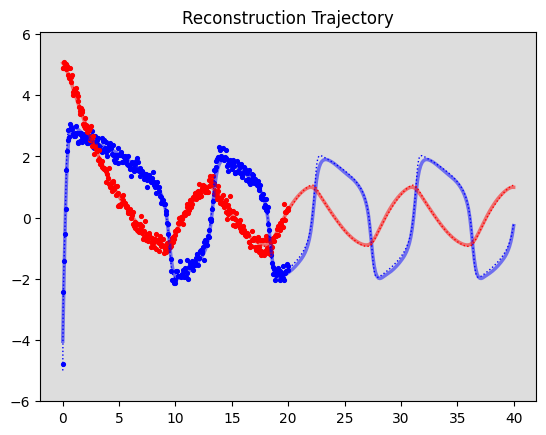

In [6]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,method="map") # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

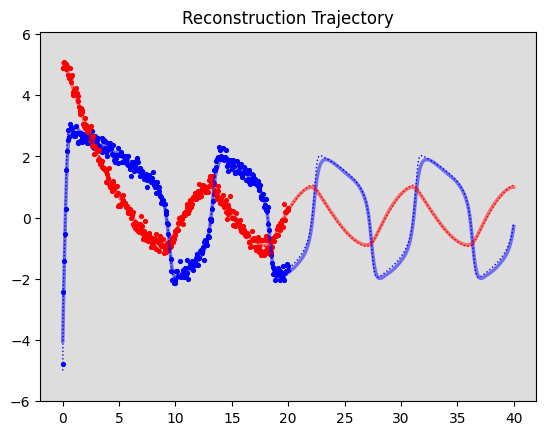

In [11]:
# reconstruction with ode numerical integration
tpred = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = tpred[tpred>np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,method="map") # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [7]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 44.984771
200/1000 iteration: 9.273745
400/1000 iteration: 5.649792
600/1000 iteration: 4.426879
800/1000 iteration: 3.836140
1000/1000 iteration: 3.491261
run time: 42.26 seconds


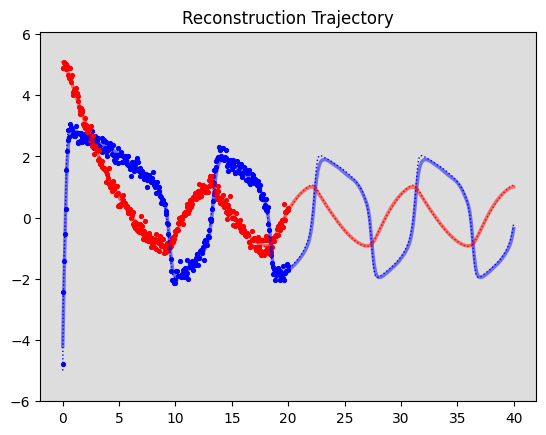

In [8]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Hes1

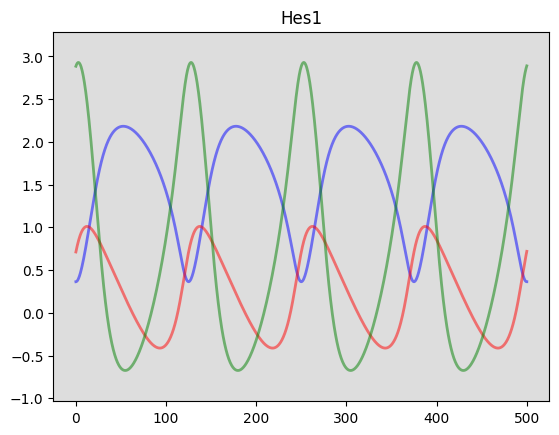

In [2]:
# define Hes1 model dynamic
def fOde(y, t, a, b, c, d, e, f, g):
	P, M, H = y
	dPdt = -a*P*H + b*M - c*P
	dMdt = -d*M + e/(1+np.power(P,2))
	dHdt = -a*P*H + f/(1+np.power(P,2)) - g*H
	return (dPdt,dMdt,dHdt)

# model parameters
a, b, c, d, e, f, g = 0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3
# initial condition
P0, M0, R0 = 1.438575, 2.037488, 17.90385
y0 = P0, M0, R0
# time point for evaluation
tdata = np.linspace(0, 500, 1281)
# integration 
xdata = odeint(fOde, y0, tdata, args = (a,b,c,d,e,f,g))
xdata = np.log(xdata)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='P')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='M')
ax.plot(tdata, xdata[:,2], 'g', alpha=0.5, lw=2, label='H')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Hes1')
plt.show()

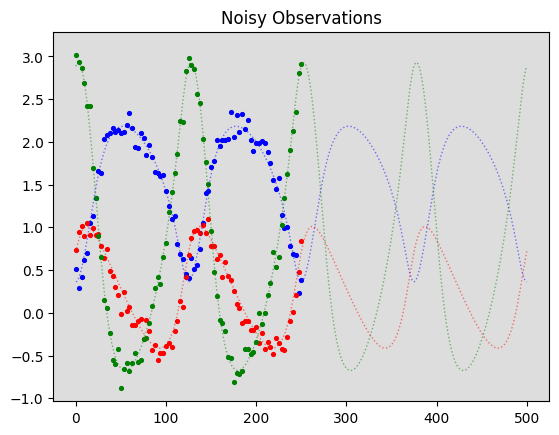

In [3]:
# setting
seed = 188714368 # random seed
noise = [0.10,0.10,0.10] # noise level
no_train = 81 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [8]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 7.703845
200/1000 iteration: 2.875090
400/1000 iteration: 1.919126
600/1000 iteration: 1.590665
800/1000 iteration: 1.456902
1000/1000 iteration: 1.393305
run time: 76.59 seconds


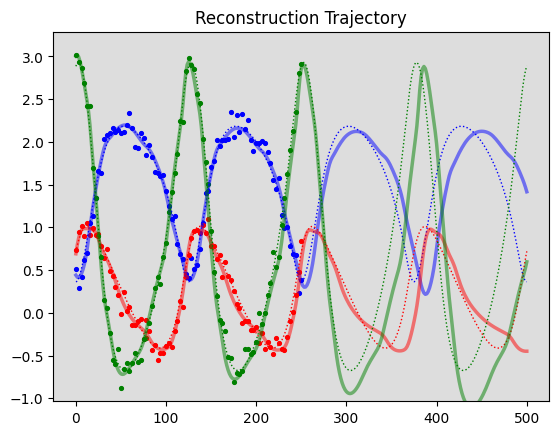

In [9]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [4]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=1e2, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

/home/chuang397/.venv/lib64/python3.8/site-packages/linear_operator/utils/sparse.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


1/1000 iteration: 7.834499
200/1000 iteration: 3.033035
400/1000 iteration: 2.087272
600/1000 iteration: 1.779080
800/1000 iteration: 1.670077
1000/1000 iteration: 1.596192
run time: 79.01 seconds


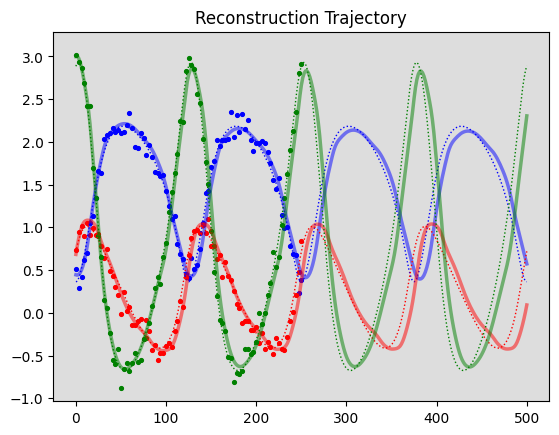

In [5]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [6]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=1e3, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 10.478333
200/1000 iteration: 4.880448
400/1000 iteration: 3.992309
600/1000 iteration: 4.287151
800/1000 iteration: 3.517886
1000/1000 iteration: 2.969291
run time: 76.95 seconds


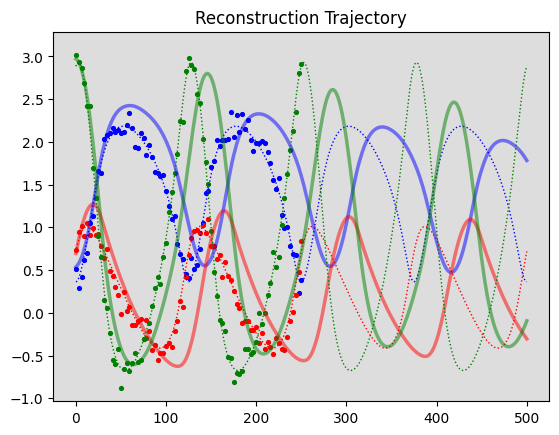

In [7]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Loren 96

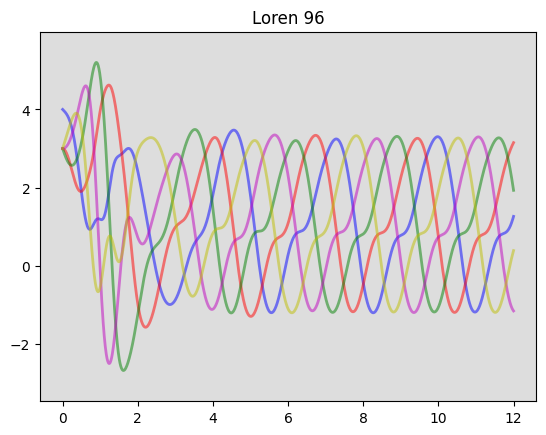

In [10]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 3
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 12.0, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

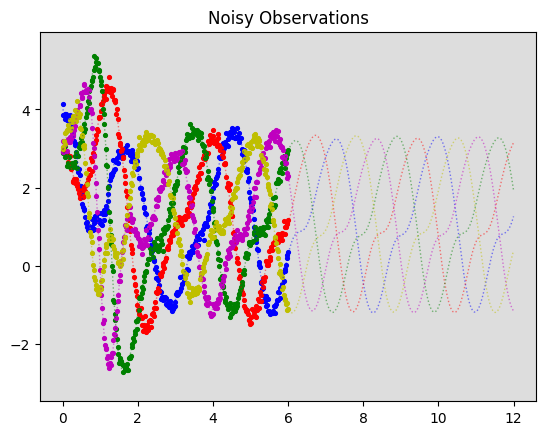

In [11]:
# setting
seed = 188714368 # random seed
noise = [0.10] * 5 # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [12]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 52.926962
200/1000 iteration: 14.006371
400/1000 iteration: 8.578664
600/1000 iteration: 7.009384
800/1000 iteration: 6.402217
1000/1000 iteration: 6.124420
run time: 139.14 seconds


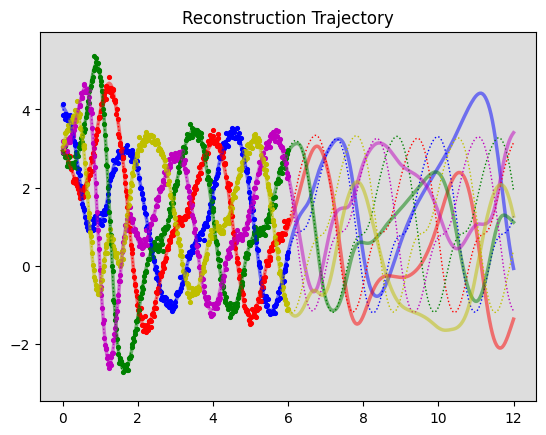

In [13]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [14]:
# reconstruction error
for i in range(no_comp):
    xi_error = xr[:,i] - xdata[np.linspace(0,tdata.size-1,321).astype(int),i]
    xi_mse_1h = np.mean(np.square(xi_error[:161]))
    xi_mse_2h = np.mean(np.square(xi_error[161:]))
    xi_mse = np.mean(np.square(xi_error))
    print(f"X{i+1}:{xi_mse:.3f}({np.sqrt(xi_mse):.3f})/{xi_mse_1h:.3f}({np.sqrt(xi_mse_1h):.3f})/{xi_mse_2h:.3f}({np.sqrt(xi_mse_2h):.3f})")


X1:1.917(1.385)/0.002(0.045)/3.845(1.961)
X2:2.277(1.509)/0.003(0.054)/4.566(2.137)
X3:1.364(1.168)/0.004(0.065)/2.732(1.653)
X4:1.454(1.206)/0.002(0.049)/2.914(1.707)
X5:2.466(1.570)/0.002(0.039)/4.946(2.224)


In [15]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=1, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 62.689821
200/1000 iteration: 29.955694
400/1000 iteration: 28.277135
600/1000 iteration: 29.102283
800/1000 iteration: 30.658369
1000/1000 iteration: 31.907271
run time: 138.22 seconds


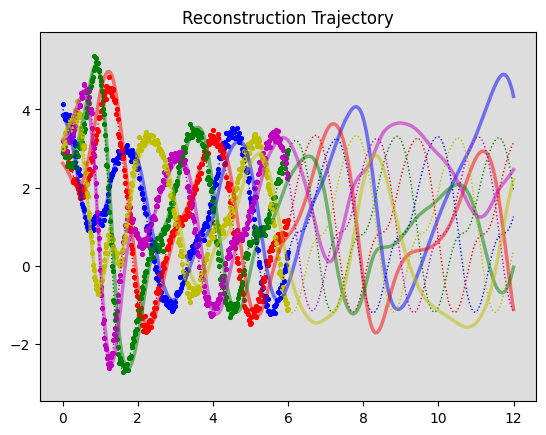

In [16]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [17]:
# reconstruction error
for i in range(no_comp):
    xi_error = xr[:,i] - xdata[np.linspace(0,tdata.size-1,321).astype(int),i]
    xi_mse_1h = np.mean(np.square(xi_error[:161]))
    xi_mse_2h = np.mean(np.square(xi_error[161:]))
    xi_mse = np.mean(np.square(xi_error))
    print(f"X{i+1}:{xi_mse:.3f}({np.sqrt(xi_mse):.3f})/{xi_mse_1h:.3f}({np.sqrt(xi_mse_1h):.3f})/{xi_mse_2h:.3f}({np.sqrt(xi_mse_2h):.3f})")

X1:3.363(1.834)/0.196(0.442)/6.551(2.560)
X2:2.317(1.522)/0.199(0.446)/4.447(2.109)
X3:2.084(1.444)/0.187(0.432)/3.994(1.998)
X4:2.397(1.548)/0.163(0.404)/4.645(2.155)
X5:3.133(1.770)/0.215(0.464)/6.069(2.464)


In [21]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=5e-1, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 55.987715
200/1000 iteration: 18.797308
400/1000 iteration: 14.822322
600/1000 iteration: 14.246990
800/1000 iteration: 14.478068
1000/1000 iteration: 14.842201
run time: 138.83 seconds


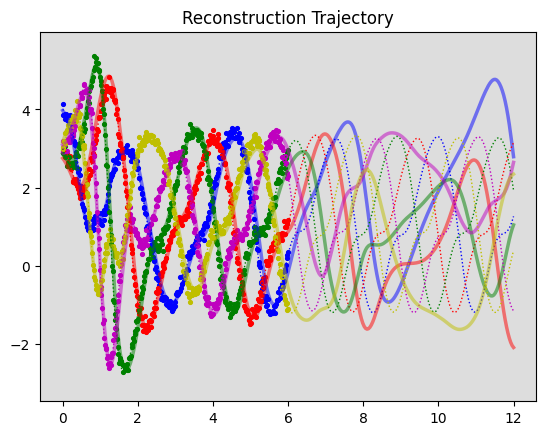

In [28]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [23]:
# reconstruction error
for i in range(no_comp):
    xi_error = xr[:,i] - xdata[np.linspace(0,tdata.size-1,321).astype(int),i]
    xi_mse_1h = np.mean(np.square(xi_error[:161]))
    xi_mse_2h = np.mean(np.square(xi_error[161:]))
    xi_mse = np.mean(np.square(xi_error))
    print(f"X{i+1}:{xi_mse:.3f}({np.sqrt(xi_mse):.3f})/{xi_mse_1h:.3f}({np.sqrt(xi_mse_1h):.3f})/{xi_mse_2h:.3f}({np.sqrt(xi_mse_2h):.3f})")

X1:2.651(1.628)/0.055(0.234)/5.263(2.294)
X2:2.200(1.483)/0.059(0.243)/4.355(2.087)
X3:1.782(1.335)/0.051(0.225)/3.525(1.877)
X4:1.811(1.346)/0.055(0.234)/3.578(1.892)
X5:2.745(1.657)/0.064(0.254)/5.443(2.333)


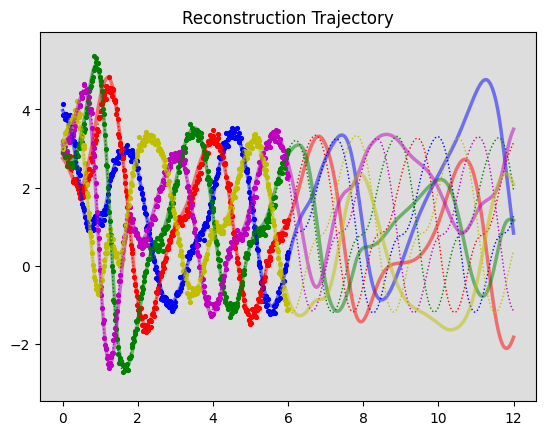

In [24]:
# reconstruction with ode numerical integration
tpred = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = tpred[tpred>np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

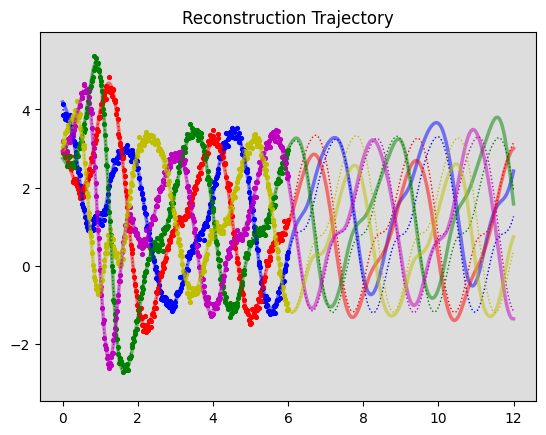

In [17]:
# reconstruction with ode numerical integration
tpred = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = tpred[tpred>np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,method="map") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Loren 96 Chaotic

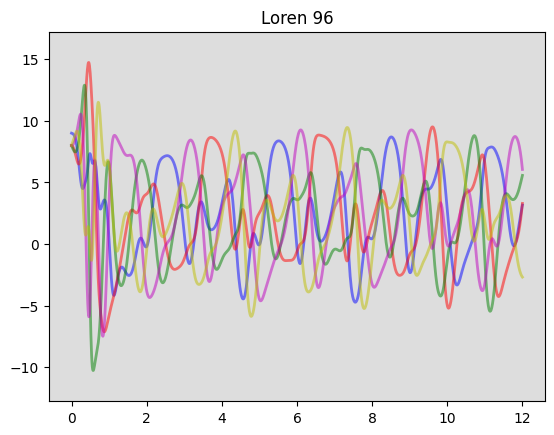

In [12]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 8
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 12.0, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

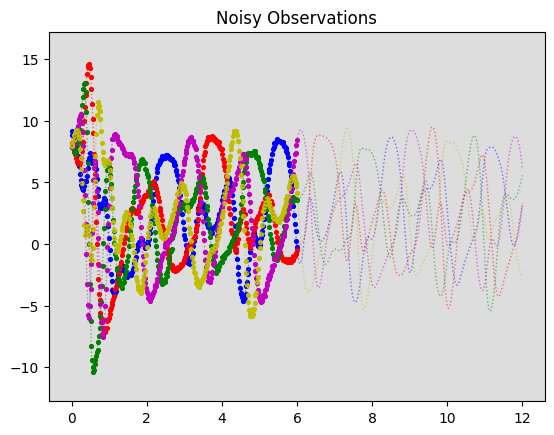

In [13]:
# setting
seed = 188714368 # random seed
noise = [0.10] * 5 # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [14]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [2048], dp=0.2) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=5000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/5000 iteration: 27.329235
1000/5000 iteration: 7.887758
2000/5000 iteration: 7.194186
3000/5000 iteration: 6.880917
4000/5000 iteration: 6.698109
5000/5000 iteration: 6.669535
run time: 587.35 seconds


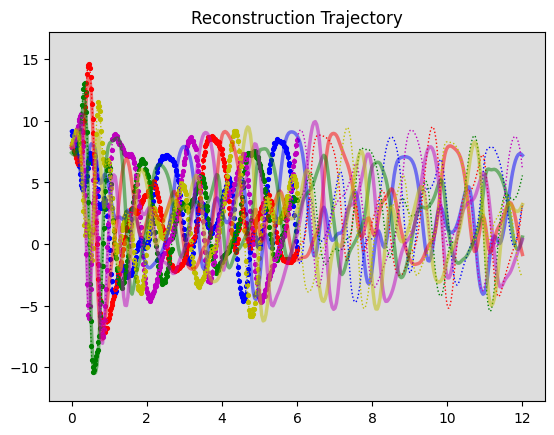

In [15]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False,method="ode") # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [16]:
# reconstruction error
for i in range(no_comp):
    xi_error = xr[:,i] - xdata[np.linspace(0,tdata.size-1,321).astype(int),i]
    xi_mse_1h = np.mean(np.square(xi_error[:161]))
    xi_mse_2h = np.mean(np.square(xi_error[161:]))
    xi_mse = np.mean(np.square(xi_error))
    print(f"X{i+1}:{xi_mse:.3f}({np.sqrt(xi_mse):.3f})/{xi_mse_1h:.3f}({np.sqrt(xi_mse_1h):.3f})/{xi_mse_2h:.3f}({np.sqrt(xi_mse_2h):.3f})")

X1:23.668(4.865)/20.194(4.494)/27.163(5.212)
X2:19.243(4.387)/13.137(3.625)/25.386(5.038)
X3:23.036(4.800)/22.599(4.754)/23.475(4.845)
X4:31.466(5.609)/28.256(5.316)/34.696(5.890)
X5:27.725(5.265)/23.397(4.837)/32.080(5.664)


### Climate Data

In [49]:
climate = pd.read_csv("data/DailyDelhiClimate.csv")
climate.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [50]:
# preprocess data
tmax = 1000 # consider only first 1000 data points for now
tdata = climate.index.to_numpy()[:tmax] # time
xdata = climate.iloc[:tmax,1:].to_numpy() # component values
xdata = np.log(xdata + 1e-3) # train it in log
xdata = (xdata - np.mean(xdata, axis=0))/np.std(xdata, axis=0) # standardization

# observation
tmax_train = 500
no_comp = xdata.shape[1] # number of components
obs = [] # set random seed for noise
for i in range(no_comp):
    tobs = tdata[:tmax_train].copy()
    yobs = xdata[:tmax_train,i].copy()
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

In [51]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=2500,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=True, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/2500 iteration: 16.038140
500/2500 iteration: 9.062147
1000/2500 iteration: 8.285702
1500/2500 iteration: 7.960746
2000/2500 iteration: 7.738599
2500/2500 iteration: 7.554101
run time: 224.33 seconds


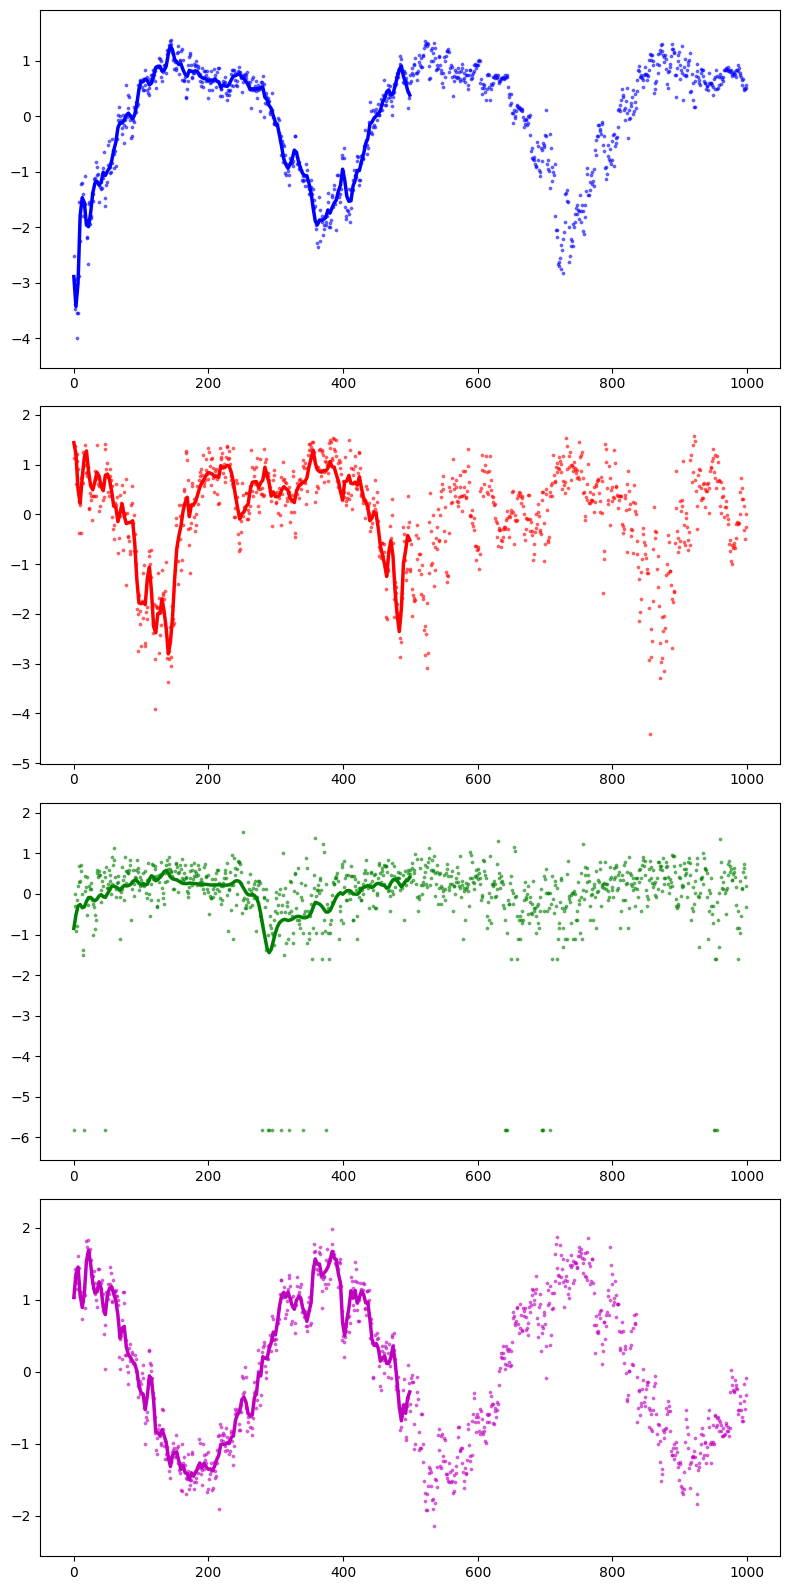

In [53]:
# inferred 
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(tinfer, xinfer[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
fig.tight_layout()
plt.show()

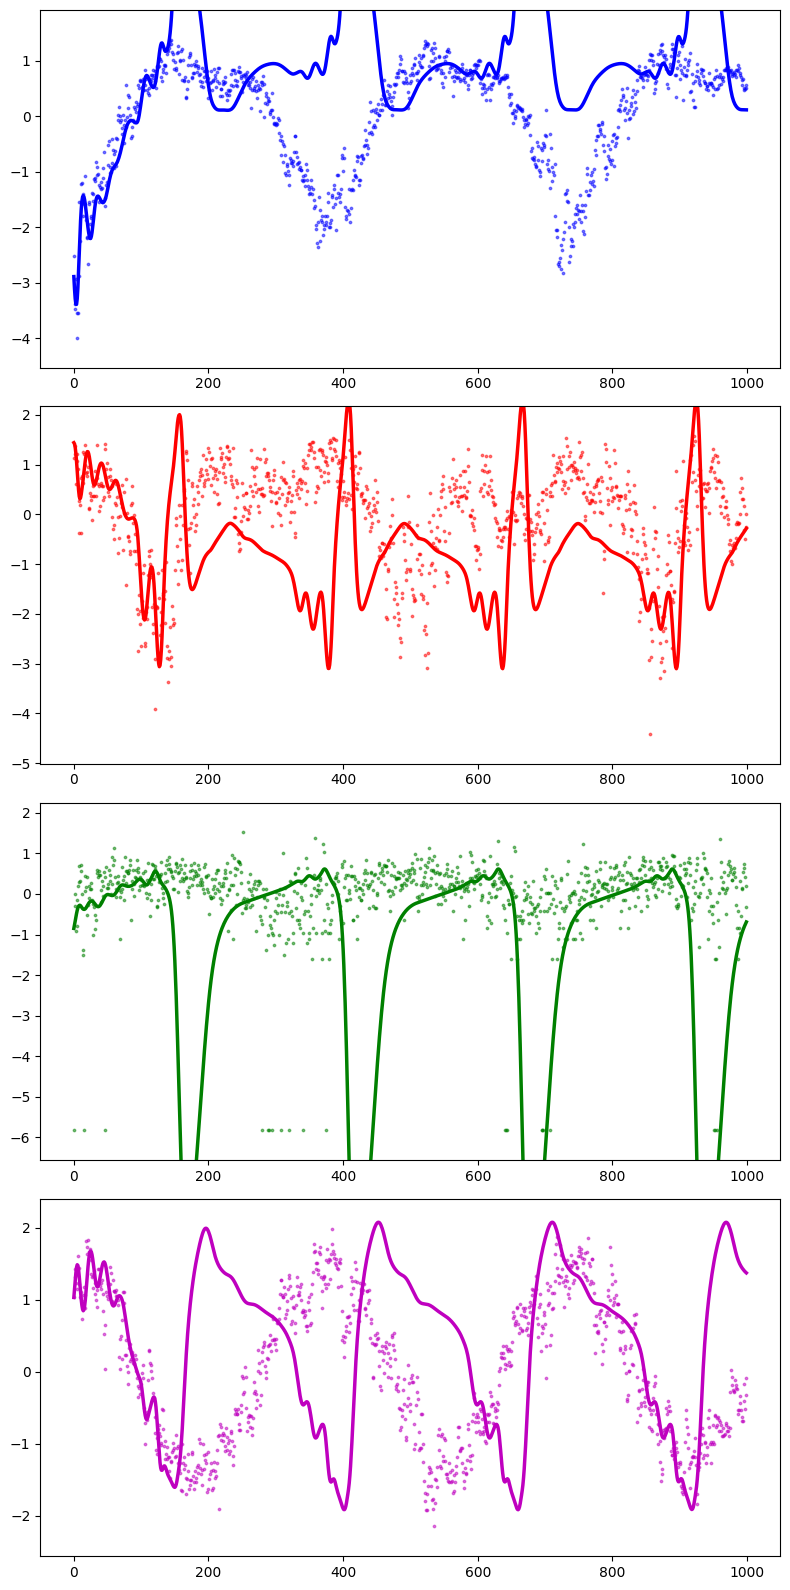

In [52]:
# reconstruction 
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(trecon, xrecon[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
fig.tight_layout()
plt.show()